# Final Project
---
## State of the art CNN architecture over imagenet dataset
---
- **Duke Mervyn Martin  (dukemerv@buffalo.edu)**
- **Preeti Kumari  (preetiku@buffalo.edu)**
- **Kizito Nwaka  (kizitonw@buffalo.edu)**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, LeakyReLU, Activation, BatchNormalization, Dropout
from keras import optimizers,regularizers
from keras.utils import plot_model
from keras.optimizers import SGD
from keras import backend 
import numpy as np
import time as t
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#tf.debugging.set_log_device_placement(True)
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='once')
import cv2
import matplotlib.image as mpimg
from keras.utils import plot_model

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Num GPUs Available:  1


### Choosing classes Randomly and Downloading 1500 Images per class

From the library [ImageNet-Datasets-Downloader](https://github.com/skaldek/ImageNet-Datasets-Downloader) we use the `downloader.py` with the command given below to download all the Images respective to its classes in each folder inside the directory `imagenet/`
```
python ./downloader.py -data_root imagenet -number_of_classes 8 -images_per_class 1500
``````

#### List of  Classes

In [4]:
from os import listdir
classes = listdir("imagenet")
print('List of Classes ->',classes)
print("Number of classes =",len(classes))

List of Classes -> ['koala', 'ladybug', 'lichen', 'meerkat', 'Rhodesian ridgeback', 'tamandua', 'vizsla', 'Yorkshire terrier']
Number of classes = 8


### Preparing the Datasets
As all the images are of different sizes, we will be generating a square image of size **n x n**

This can be acheived by two steps
- Scale down the image to n pixels by its shortest side
- Crop the middle part of the image to get n x n pixels square
(This method of data preparation is used by AlexNet model, VGG-16 & VGG-19)

In [2]:
n = 128

## Image process demo

Image Before Processing
-----------------------


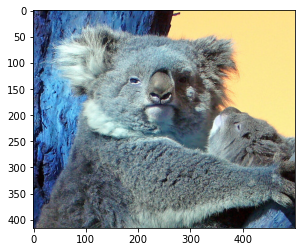

(416, 500, 3)
Image After Resizing
-----------------------


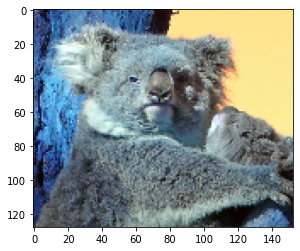

(128, 153, 3)
Image After Croping
-----------------------
(128, 128, 3)


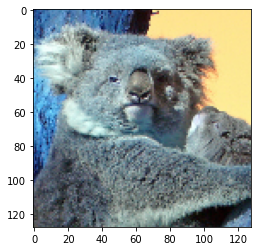

In [5]:
img = cv2.imread('imagenet/koala/218758752_650f6b9b5a.jpg')
print('Image Before Processing')
print('-----------------------')
plt.imshow(img)
plt.show()
print(img.shape)
print('Image After Resizing')
print('-----------------------')
if(img.shape[0]>img.shape[1]):
    width = n
    height = int(img.shape[0] * (n/img.shape[1]))
    img = cv2.resize(img,(width,height))
    plt.imshow(img)
    plt.show()
    print(img.shape)
else:
    width = int(img.shape[1] * (n/img.shape[0]))
    height = n
    img = cv2.resize(img,(width,height))
    plt.imshow(img)
    plt.show()
    print(img.shape)
print('Image After Croping')
print('-----------------------')
if(img.shape[0]==n):
    x = int((img.shape[1]-n)/2)
    img = img[0:,x:x+n]
    plt.imshow(img)
    print(img.shape)
else:
    x = int((img.shape[0]-n)/2)
    img = img[x:x+n,0:]
    plt.imshow(img)
    plt.show()
    print(img.shape)

#### Preprocessing Images

In [4]:
def img_process(image):
    img = image
    if(img.shape[0]>img.shape[1]):
        width = n
        height = int(img.shape[0] * (n/img.shape[1]))
        img = cv2.resize(img,(width,height))
    else:
        width = int(img.shape[1] * (n/img.shape[0]))
        height = n
        img = cv2.resize(img,(width,height))

    if(img.shape[0]==n):
        x = int((img.shape[1]-n)/2)
        img = img[0:,x:x+n]
    else:
        x = int((img.shape[0]-n)/2)
        img = img[x:x+n,0:]
    img = cv2.resize(img,(n,n))
    return img

#### Generate Target Labels

In [7]:
labels= [] # Target Classes
for name in classes:
    for jpg in listdir("imagenet/"+name):
        labels.append([name])

#### Generate Colour Image Datasets after applying the preprocessing function

In [8]:
labels=np.array(labels)

In [9]:
labels.shape

(12000, 1)

In [10]:
images = np.zeros((labels.shape[0],n,n,3)) #Empty Dataset
i=0
for name in classes:
    for jpg in listdir("imagenet/"+name):
        img = cv2.imread('imagenet/'+name+'/'+jpg)
        img = img_process(img) 
        images[i] = img
        i+=1
print('Image data shape ->',images.shape)

Image data shape -> (12000, 128, 128, 3)


In [11]:
# Save the Data for future use
np.save('image_data_128_color',images)
np.save('image_label_128_color',labels)

In [4]:
image_data= np.load('image_data_128_color.npy')
labels= np.load('image_label_128_color.npy')

In [5]:
print('Check Max Min before Normalization ->',image_data.min(),image_data.max())
image_data = image_data/255
print('Check Max Min after Normalization ->',image_data.min(),image_data.max())

Check Max Min before Normalization -> 0.0 255.0
Check Max Min after Normalization -> 0.0 1.0


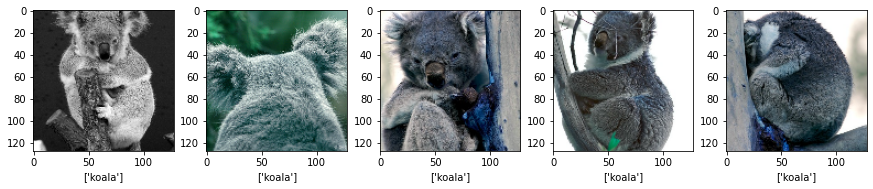

In [6]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(image_data[i])
    plt.xlabel(labels[i])
plt.show()

### Split Training and Testing Data

In [8]:
from sklearn.utils import shuffle

image_data,labels = shuffle(image_data,labels)
np.save('shuffled_images_128',image_data)
np.save('shuffled_label_128',labels)

* We use a common shuffled data for analysing the performance of all the models, thus we reduce the effect of shuffling attributing to the accuracy of the model.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

c:\users\dm97o\anaconda3\envs\tf_gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
images= np.load('shuffled_images_128.npy')
labels= np.load('shuffled_label_128.npy')

* We load the shuffled data and encode the labels using the onehot encoder.

In [6]:
label_encoder = OneHotEncoder()
label_encoder.fit(labels)
label_encoded = label_encoder.transform(labels).toarray()
train_images, test_images = images[0:10000],images[10000:]
train_labels, test_labels = label_encoded[0:10000],label_encoded[10000:]

### Some statistics about the data

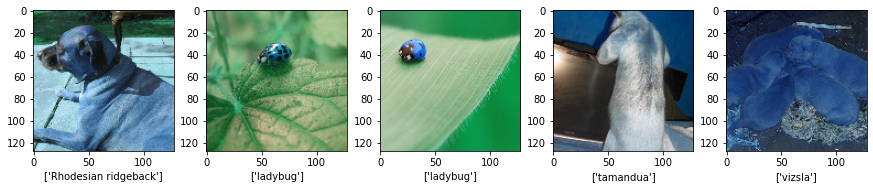

In [7]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i])
    plt.xlabel(labels[i])
plt.show()

In [8]:
print(labels[:5])
print(label_encoded[:5])

[['Rhodesian ridgeback']
 ['ladybug']
 ['ladybug']
 ['tamandua']
 ['vizsla']]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [9]:
print('Total Number of Entries ->',len(labels))
print('X Train Shape ->',train_images.shape)
print('Y Train Shape ->',train_labels.shape)
print('X Test Shape ->',test_images.shape)
print('Y Test Shape ->',test_labels.shape)

Total Number of Entries -> 12000
X Train Shape -> (10000, 128, 128, 3)
Y Train Shape -> (10000, 8)
X Test Shape -> (2000, 128, 128, 3)
Y Test Shape -> (2000, 8)


In [8]:
 def graphs(history,score):

    plt.figure(figsize=(15,7))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy',size=20)
    plt.ylabel('Accuracy',size=15)
    plt.xlabel('Epochs', size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()
    
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',size=20)
    plt.ylabel('Loss',size=15)
    plt.xlabel('Epochs',size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()
    
    print("Accuracy of the model: {:.2f}%".format(score[1]*100))

### Building the network

In [9]:
opt = SGD(lr=0.01,momentum=0.9,decay=0.01)

In [10]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=0, mode='auto')

## VGG - 16

## VGG Archietectures
---

- **VGG model** was presented as an invetigation of the effect of depth on the accuracy of a CNN architecture on a large scale image recognition setting. 
- The key idea is to use very small (3 x 3) filters and increasing the number of layers (depth of the network)
- We build and analyse the performance of the VGG - 16 on the MNIST digit dataset.

### VGG - 16
- As the name says, it consits of 16 weight layers (13 convolution and 3 Fully connected layers). The original paper used 224 x 224 colored images of the ImageNet dataset (ILSVRC).
- The original model took very less epochs to converge when compared to the other proposals even with a shallow network due to the ***implicit regularisation imposed by greater depth and smaller conv filter sizes***.
- The images were randomly cropped and flipped both horizontally & verticaly to provide data augumentation.
- We implement VGG-16 on a more simpler MNIST digit dataset.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 256)      

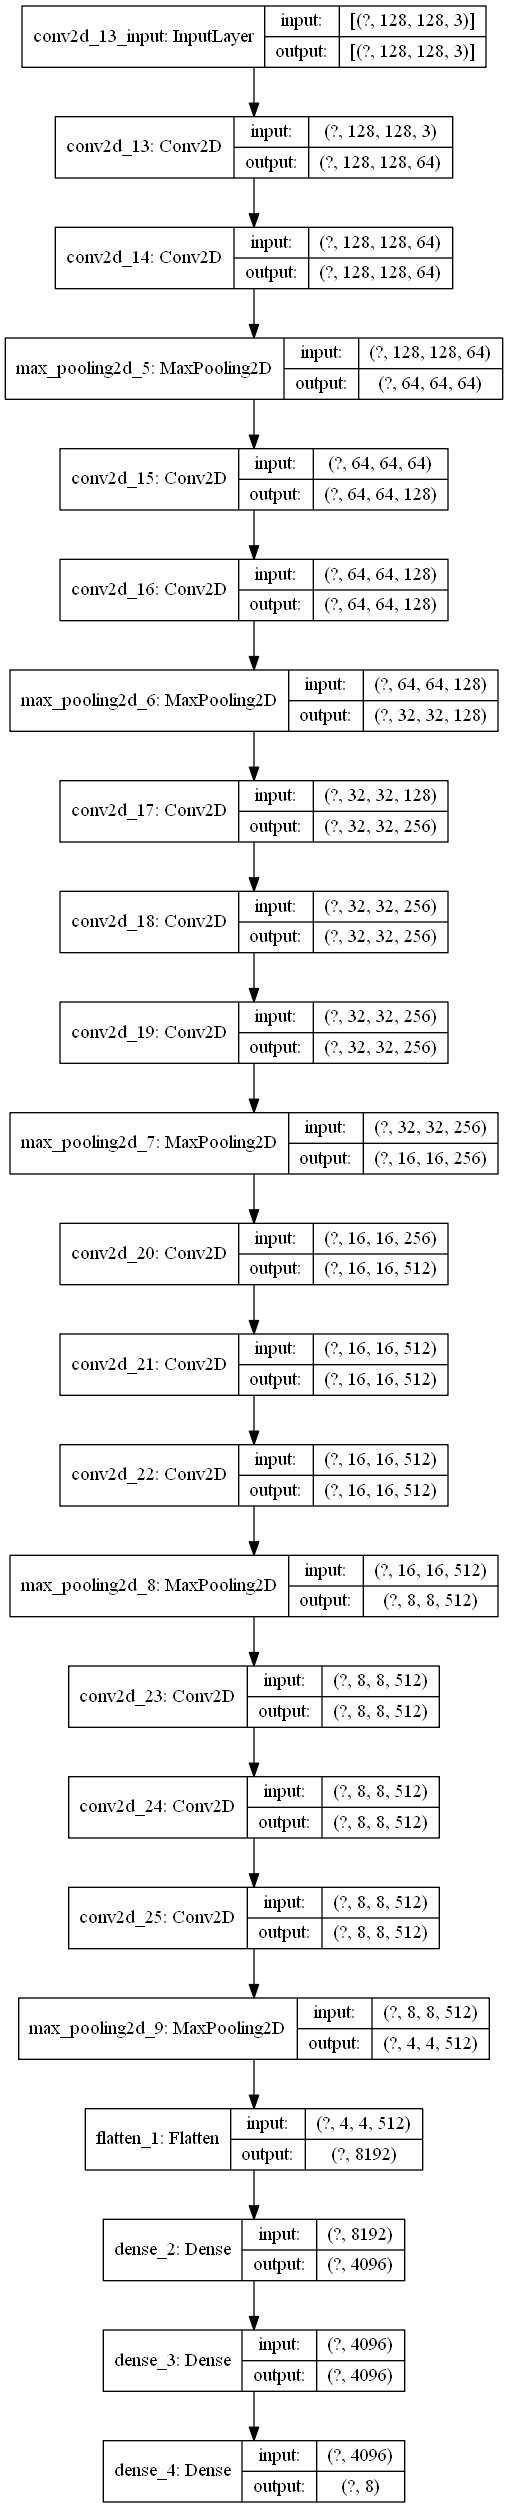

In [5]:
model = Sequential()
model.add(Conv2D(input_shape=(n,n,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dense(4096,activation="relu"))
model.add(Dense(units=len(classes), activation="softmax"))
model.summary()
plot_model(model, show_shapes=True, to_file='VGG_16.png')

In [12]:
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
start_time=t.time()
history = model.fit(train_images, train_labels,
          validation_data=(test_images, test_labels), 
          epochs=50, batch_size=64, callbacks=[early])
print("\n Training Time: {} seconds".format(t.time()-start_time))
model.save('vgg_16_n128_colour.h5')

Epoch 1/50
157/157 [==============================] - 79s 505ms/step - loss: 2.0793 - accuracy: 0.1195 - val_loss: 2.0783 - val_accuracy: 0.1150
Epoch 2/50
157/157 [==============================] - 78s 498ms/step - loss: 2.0742 - accuracy: 0.1630 - val_loss: 2.0662 - val_accuracy: 0.2225
Epoch 3/50
157/157 [==============================] - 79s 501ms/step - loss: 2.0235 - accuracy: 0.2206 - val_loss: 1.9504 - val_accuracy: 0.2410
Epoch 4/50
157/157 [==============================] - 79s 504ms/step - loss: 1.8996 - accuracy: 0.2752 - val_loss: 1.8147 - val_accuracy: 0.3220
Epoch 5/50
157/157 [==============================] - 79s 505ms/step - loss: 1.7712 - accuracy: 0.3287 - val_loss: 1.8372 - val_accuracy: 0.2985
Epoch 6/50
157/157 [==============================] - 79s 505ms/step - loss: 1.6641 - accuracy: 0.3756 - val_loss: 1.6350 - val_accuracy: 0.3815
Epoch 7/50
157/157 [==============================] - 79s 506ms/step - loss: 1.6170 - accuracy: 0.3905 - val_loss: 1.5708 - val_ac

Test Loss -  1.1692144870758057
Test Accuracy -  0.6004999876022339


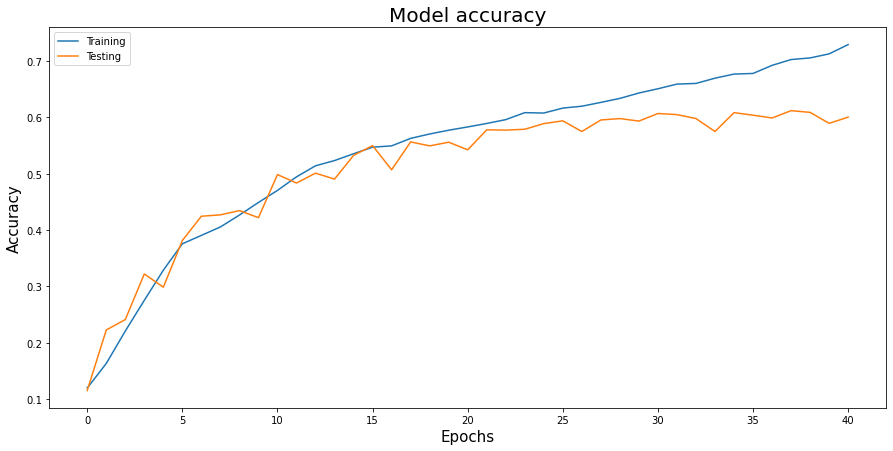

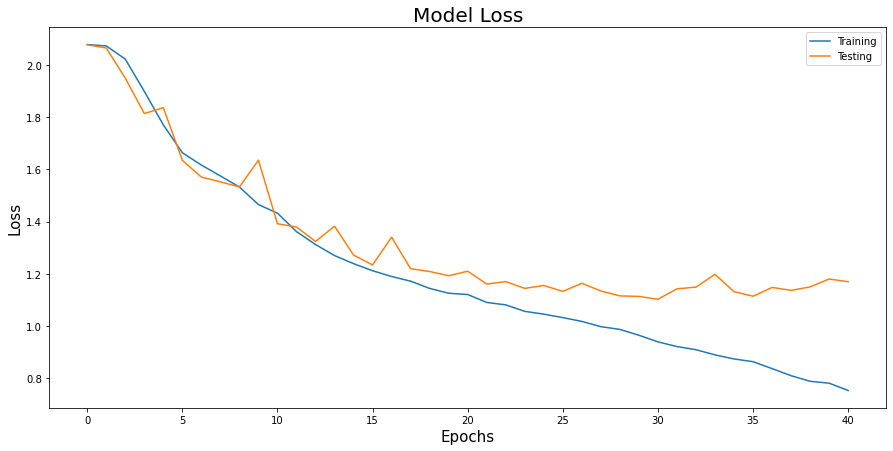

Accuracy of the model: 60.05%


In [14]:
score = model.evaluate(test_images,test_labels,verbose=0)
print('Test Loss - ',score[0])
print('Test Accuracy - ',score[1])
graphs(history,score)

## VGG - 19
---
* It is a variation of the VGG-19, with 19 weight layers, 16 from convolution and 3 from the FC

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 256)      

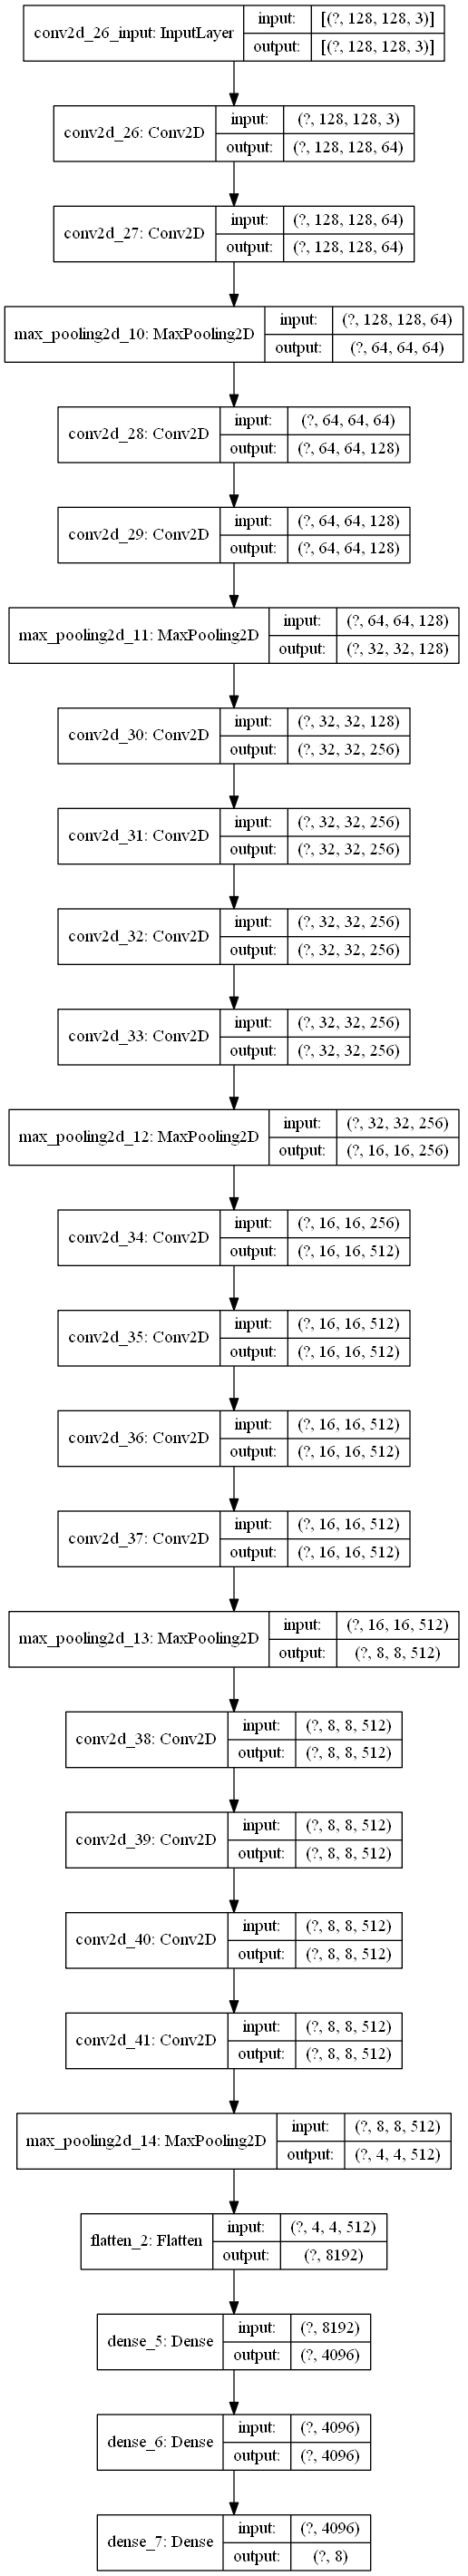

In [6]:
#vgg-19
model2 = Sequential()
model2.add(Conv2D(input_shape=(n,n,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(Conv2D(64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model2.add(Flatten())
model2.add(Dense(4096,activation="relu"))
model2.add(Dense(4096,activation="relu"))
model2.add(Dense(units=len(classes), activation="softmax"))
model2.summary()
plot_model(model2, show_shapes=True, to_file='VGG_19.png')

In [15]:
model2.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
start_time=t.time()
history2 = model2.fit(train_images, train_labels,
          validation_data=(test_images, test_labels), 
          epochs=100, batch_size=64,callbacks=[early])
print("\n Training Time: {} seconds".format(t.time()-start_time))
model2.save('vgg_19_n128_colour.h5')

Epoch 1/100
157/157 [==============================] - 93s 593ms/step - loss: 2.0799 - accuracy: 0.1212 - val_loss: 2.0801 - val_accuracy: 0.1150
Epoch 2/100
157/157 [==============================] - 91s 583ms/step - loss: 2.0795 - accuracy: 0.1250 - val_loss: 2.0800 - val_accuracy: 0.1150
Epoch 3/100
157/157 [==============================] - 92s 583ms/step - loss: 2.0792 - accuracy: 0.1252 - val_loss: 2.0796 - val_accuracy: 0.1150
Epoch 4/100
157/157 [==============================] - 92s 583ms/step - loss: 2.0788 - accuracy: 0.1253 - val_loss: 2.0792 - val_accuracy: 0.1150
Epoch 5/100
157/157 [==============================] - 92s 584ms/step - loss: 2.0781 - accuracy: 0.1378 - val_loss: 2.0783 - val_accuracy: 0.1430
Epoch 6/100
157/157 [==============================] - 92s 584ms/step - loss: 2.0765 - accuracy: 0.1804 - val_loss: 2.0760 - val_accuracy: 0.1695
Epoch 7/100
157/157 [==============================] - 92s 583ms/step - loss: 2.0733 - accuracy: 0.2111 - val_loss: 2.0715 -

Test Loss -  1.259333610534668
Test Accuracy -  0.5580000281333923


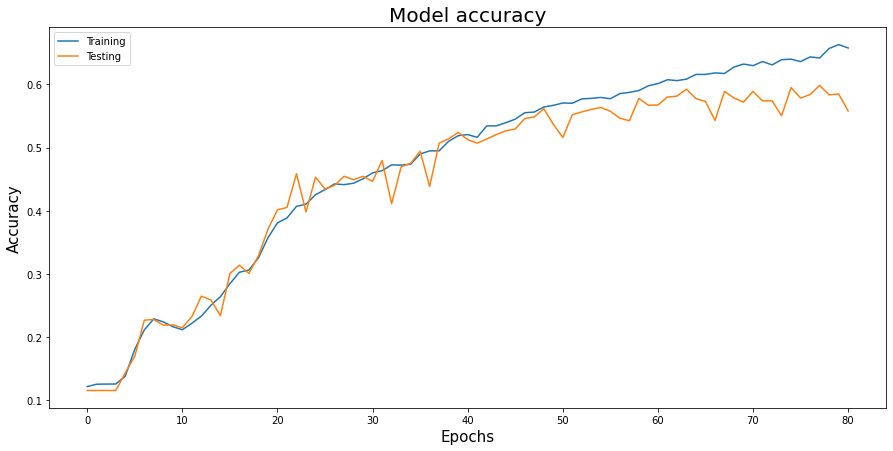

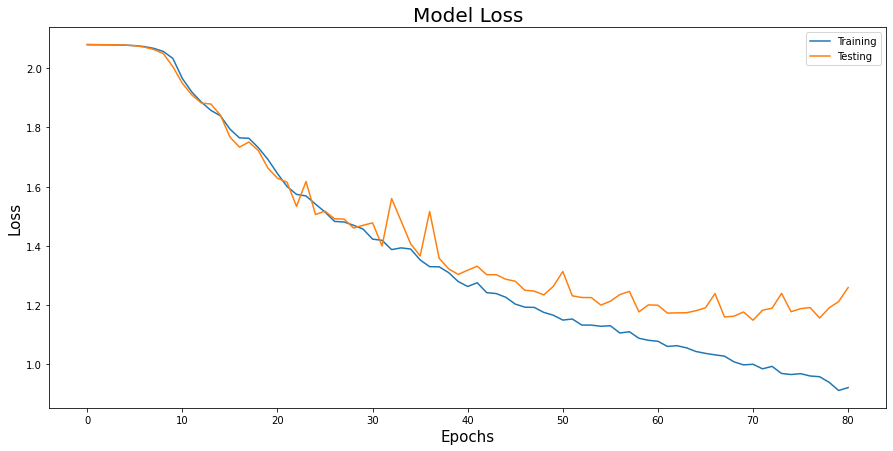

Accuracy of the model: 55.80%


In [17]:
score2 = model2.evaluate(test_images,test_labels,verbose=0)
print('Test Loss - ',score2[0])
print('Test Accuracy - ',score2[1])
graphs(history2,score2)

## AlexNet
---
* It is comparetively a very small network with only 5 convolution layers and varying filter sizes.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 30, 30, 96)        34944     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 256)       614656    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 6, 6, 384)         885120    
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 6, 6, 256)        

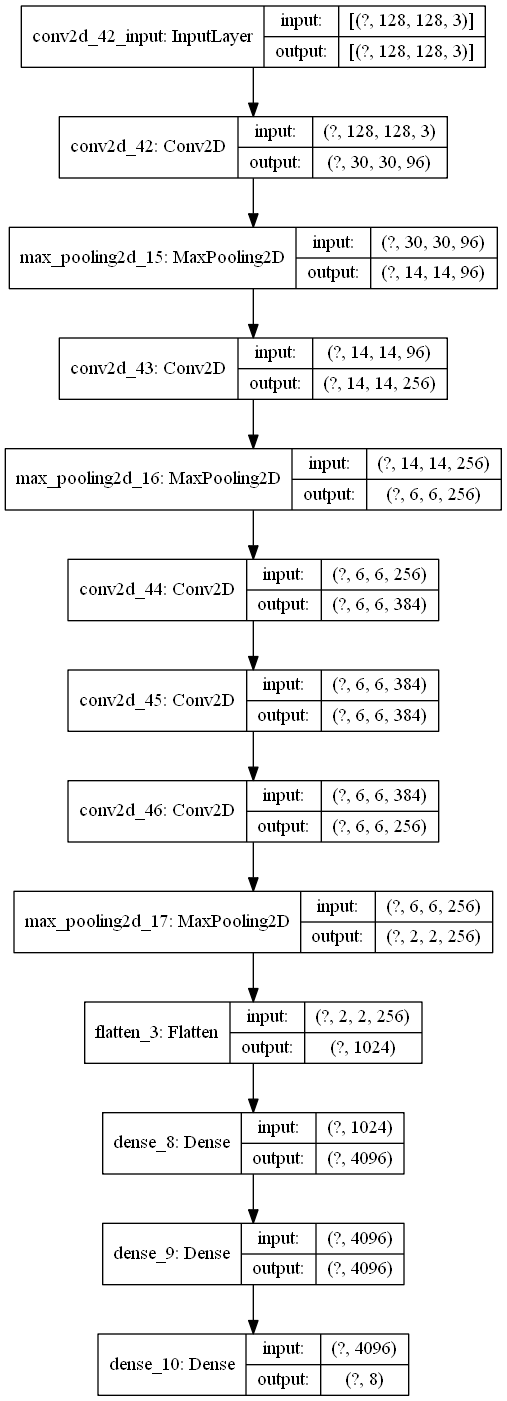

In [7]:
#alexnet
model3 = Sequential()
model3.add(Conv2D(input_shape=(n,n,3),filters=96,kernel_size=(11,11),strides=(4,4),padding="valid", activation="relu"))
model3.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model3.add(Conv2D(256, kernel_size=(5,5), padding="same",strides=(1,1), activation="relu"))
model3.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model3.add(Conv2D(384, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu"))
model3.add(Conv2D(384, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu"))
model3.add(Conv2D(256, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu"))
model3.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model3.add(Flatten())
model3.add(Dense(4096,activation="relu"))
model3.add(Dense(4096,activation="relu"))
model3.add(Dense(units=len(classes), activation="softmax"))
model3.summary()
plot_model(model3, show_shapes=True, to_file='ALEX_NET.png')

In [12]:
model3.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
start_time=t.time()
history3 = model3.fit(train_images, train_labels,
          validation_data=(test_images, test_labels), 
          epochs=100, batch_size=64,callbacks=[early])
print("\n Training Time: {} seconds".format(t.time()-start_time))
model3.save('alexnet_n128_colour.h5')

Epoch 1/100
157/157 [==============================] - 8s 54ms/step - loss: 1.9990 - accuracy: 0.2024 - val_loss: 1.8580 - val_accuracy: 0.3075
Epoch 2/100
157/157 [==============================] - 8s 49ms/step - loss: 1.7447 - accuracy: 0.3254 - val_loss: 1.9200 - val_accuracy: 0.2960
Epoch 3/100
157/157 [==============================] - 8s 49ms/step - loss: 1.5547 - accuracy: 0.4045 - val_loss: 1.4474 - val_accuracy: 0.4690
Epoch 4/100
157/157 [==============================] - 8s 49ms/step - loss: 1.3725 - accuracy: 0.4887 - val_loss: 1.3616 - val_accuracy: 0.4940
Epoch 5/100
157/157 [==============================] - 8s 49ms/step - loss: 1.2997 - accuracy: 0.5190 - val_loss: 1.4937 - val_accuracy: 0.4405
Epoch 6/100
157/157 [==============================] - 8s 49ms/step - loss: 1.2072 - accuracy: 0.5506 - val_loss: 1.2207 - val_accuracy: 0.5485
Epoch 7/100
157/157 [==============================] - 8s 49ms/step - loss: 1.1483 - accuracy: 0.5744 - val_loss: 1.2489 - val_accuracy:

Test Loss -  0.888465404510498
Test Accuracy -  0.6850000023841858


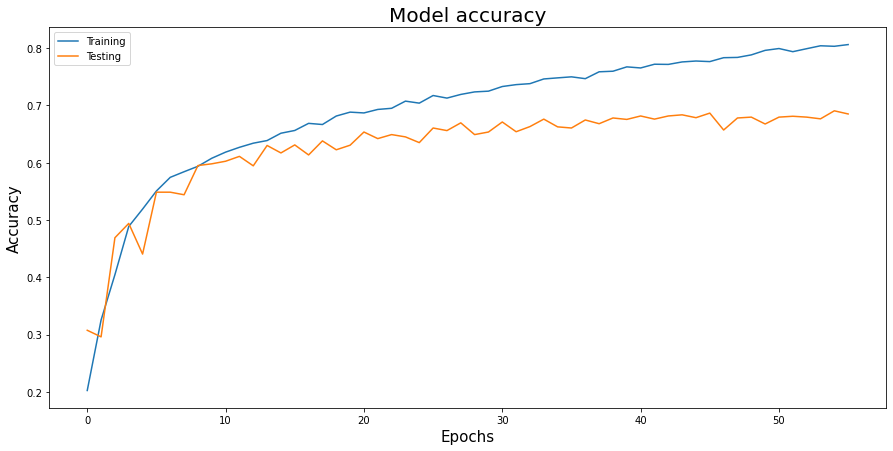

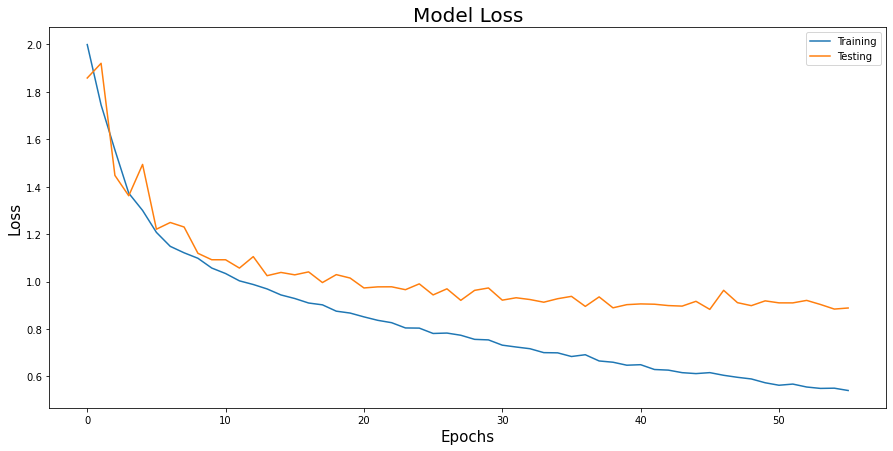

Accuracy of the model: 68.50%


In [14]:
score3 = model3.evaluate(test_images,test_labels,verbose=0)
print('Test Loss - ',score3[0])
print('Test Accuracy - ',score3[1])
graphs(history3,score3)

## Inception Module
* Some ideas on the inception module implementation from: 
[1] F. SHAIKH, "Inception Network | Implementation Of GoogleNet In Keras", Analytics Vidhya, 2020. [Online]. Available: https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/. [Accessed: 12- Aug- 2020]

In [8]:
# function for creating a projected inception module (performance improved)
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

## Let's test our function

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 96) 384         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 16) 64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
_______________________________________________________________________________________

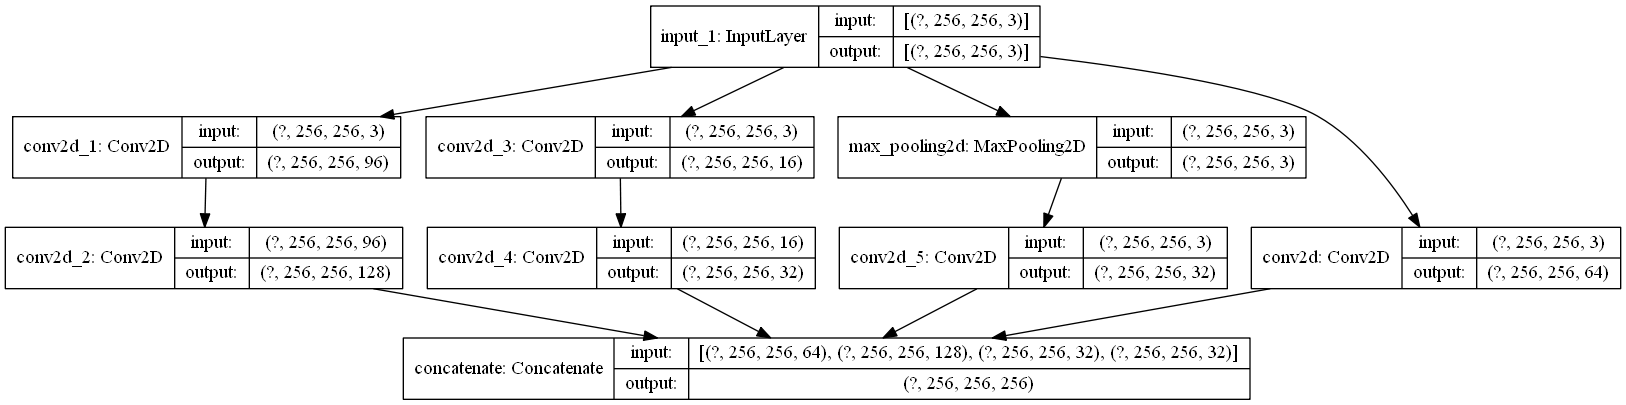

In [9]:
visible = Input(shape=(256, 256, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True)

## GoogleNet using inception module
### Relevant sources 

[1] C. Szegedy et al., "Going deeper with convolutions," 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, 2015, pp. 1-9, doi: 10.1109/CVPR.2015.7298594.

In [10]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 64)   4160        max_pooling2d_1[0][0]            
_______________________________________________________________________________________

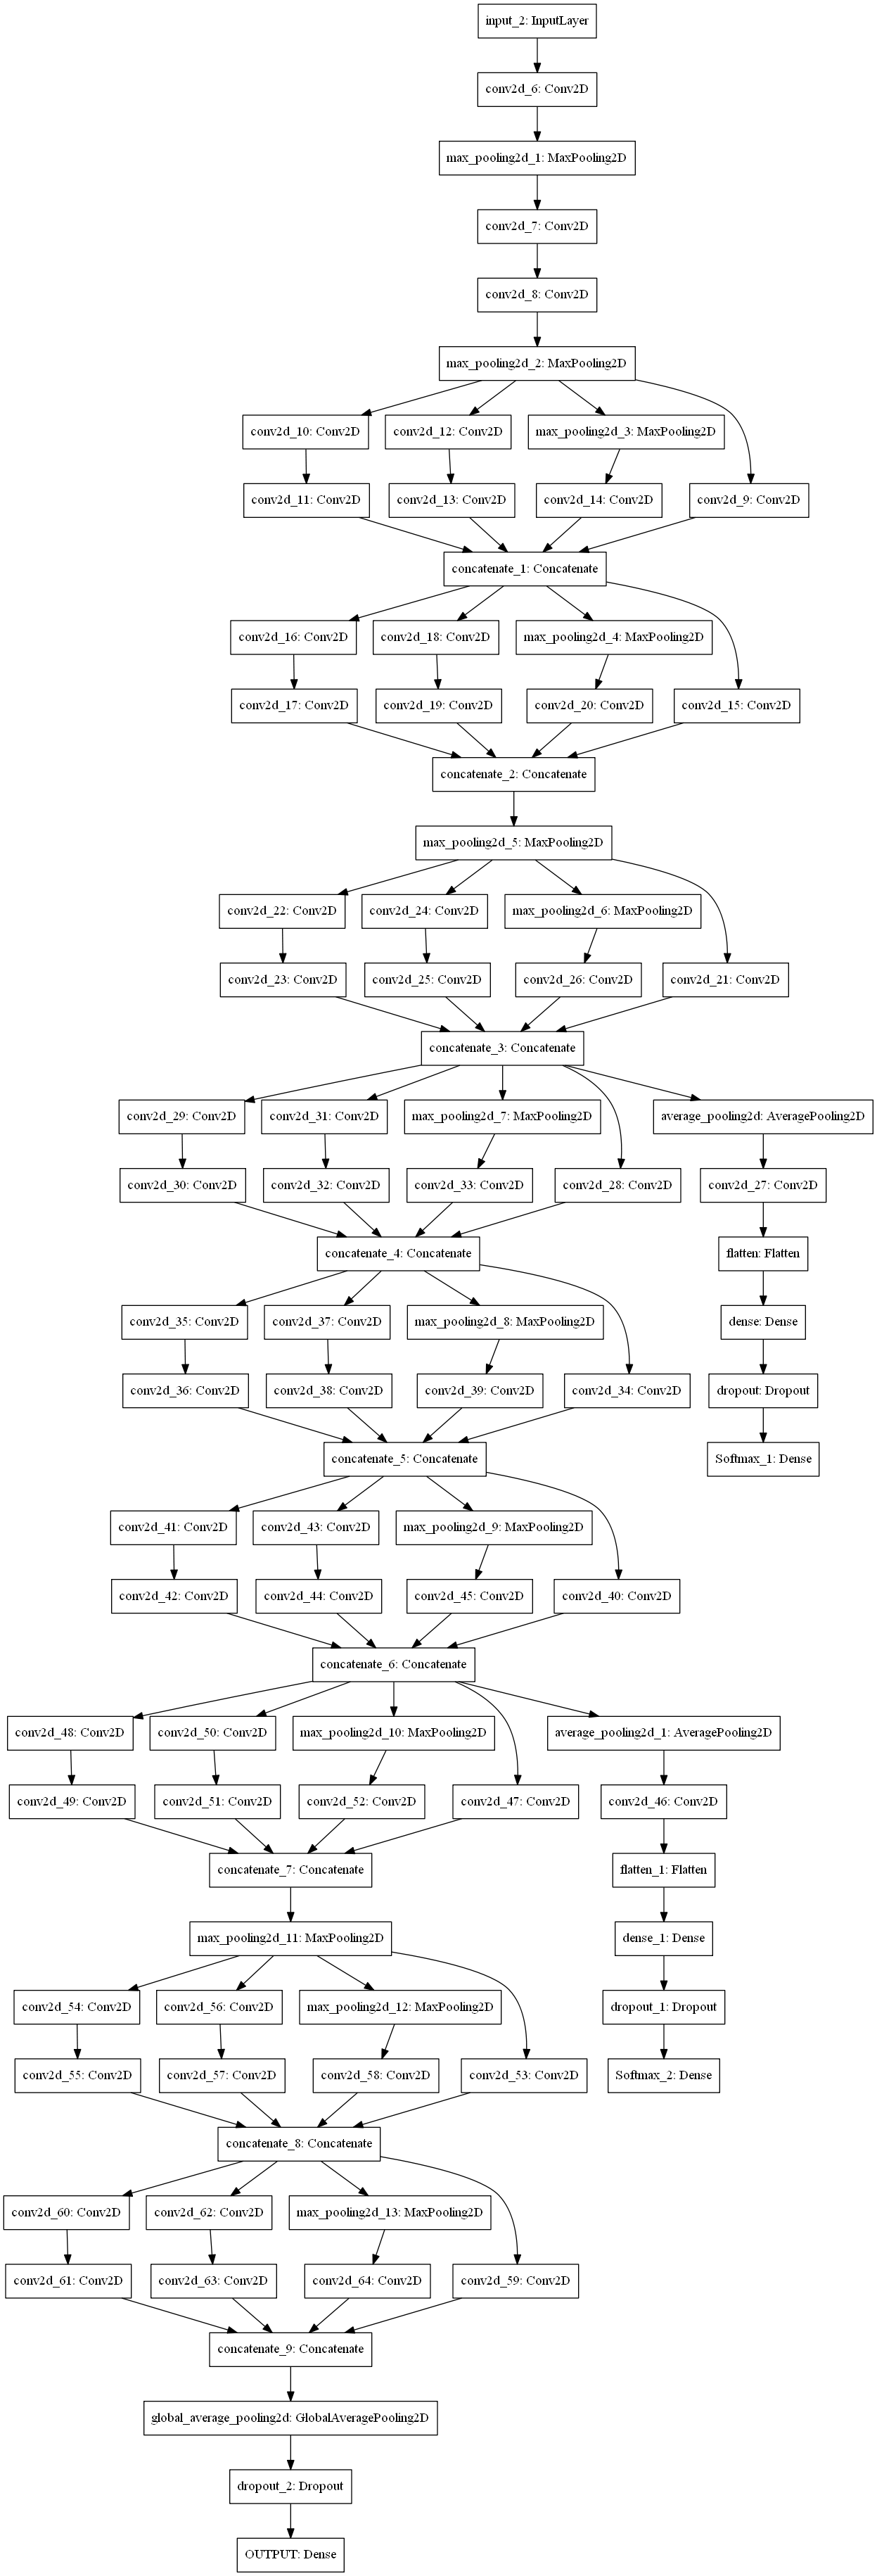

In [12]:
# define model input
input_layer = Input(shape=(128, 128, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu',kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

x = inception_module(x, 64, 96, 128, 16, 32, 32)#3a
x = inception_module(x, 128, 128, 192, 32, 96, 64)#3b
x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

x = inception_module(x, 192, 96, 208, 16, 48, 64) #4a

x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(len(classes), activation='softmax', name="Softmax_1")(x1)

x = inception_module(x, 160, 112, 224, 24, 64, 64) #4b
x = inception_module(x, 128, 128, 256, 24, 64, 64) #4c
x = inception_module(x, 112, 144, 288, 32, 64, 64) #4d

x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(len(classes), activation='softmax',name="Softmax_2")(x2)

x = inception_module(x, 256, 160, 320, 32, 128, 128) #4e

x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

x = inception_module(x, 256, 160, 320, 32, 128, 128) #5a
x = inception_module(x, 384, 192, 384, 48, 128, 128 ) #5b

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(len(classes), activation='softmax',name="OUTPUT")(x)

model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()
plot_model(model)

In [13]:
epochs = 50
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [14]:
history = model.fit(train_images, [train_labels,train_labels,train_labels], validation_data=(test_images, [test_labels,test_labels,test_labels]), epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/50
40/40 [==============================] - 76s 2s/step - loss: 6.2381 - OUTPUT_loss: 2.0800 - Softmax_1_loss: 2.0787 - Softmax_2_loss: 2.0795 - OUTPUT_accuracy: 0.1202 - Softmax_1_accuracy: 0.1354 - Softmax_2_accuracy: 0.1252 - val_loss: 6.2335 - val_OUTPUT_loss: 2.0794 - val_Softmax_1_loss: 2.0748 - val_Softmax_2_loss: 2.0793 - val_OUTPUT_accuracy: 0.1195 - val_Softmax_1_accuracy: 0.1925 - val_Softmax_2_accuracy: 0.1195

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/50
40/40 [==============================] - 58s 1s/step - loss: 6.2260 - OUTPUT_loss: 2.0785 - Softmax_1_loss: 2.0700 - Softmax_2_loss: 2.0775 - OUTPUT_accuracy: 0.1307 - Softmax_1_accuracy: 0.1569 - Softmax_2_accuracy: 0.1378 - val_loss: 6.2009 - val_OUTPUT_loss: 2.0758 - val_Softmax_1_loss: 2.0516 - val_Softmax_2_loss: 2.0734 - val_OUTPUT_accuracy: 0.2115 - val_Softmax_1_accuracy: 0.2090 - val_Softmax_2_accuracy: 0.1

In [17]:
model.save('googlenet_n128_colour.h5')

In [20]:
from keras.models import load_model
model=load_model('googlenet_n128_colour.h5')

In [24]:
score = model.evaluate(test_images,test_labels,verbose=0)
print('Test Loss - ',score[3])
print('Test Accuracy - ',score[5])

Test Loss -  0.9102452397346497
Test Accuracy -  0.6974999904632568


## Residual Module
---
* Residual Model solves the problem of vanishing gradient. The idea is to add a shortcut layer for the flow of information from one layer to another which improves the performance of the model.

* Let H(x) be the underlying mapping to be fit by a deep network, where x is the input to the first layer and the output will be F(x).The residual function is H(x)-x and after approximation we achieve F(x)+x. So we add the input ‘x’ to the output function before feeding it to the activation layer.

* Ref: https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

In [11]:
#Residual Block :- 2 Conv layer, 64 : 3x3 filters, Relu activation function
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

## ResNet using residual module

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 256         input_1[0][0]                    
_______________________________________________________________________________________

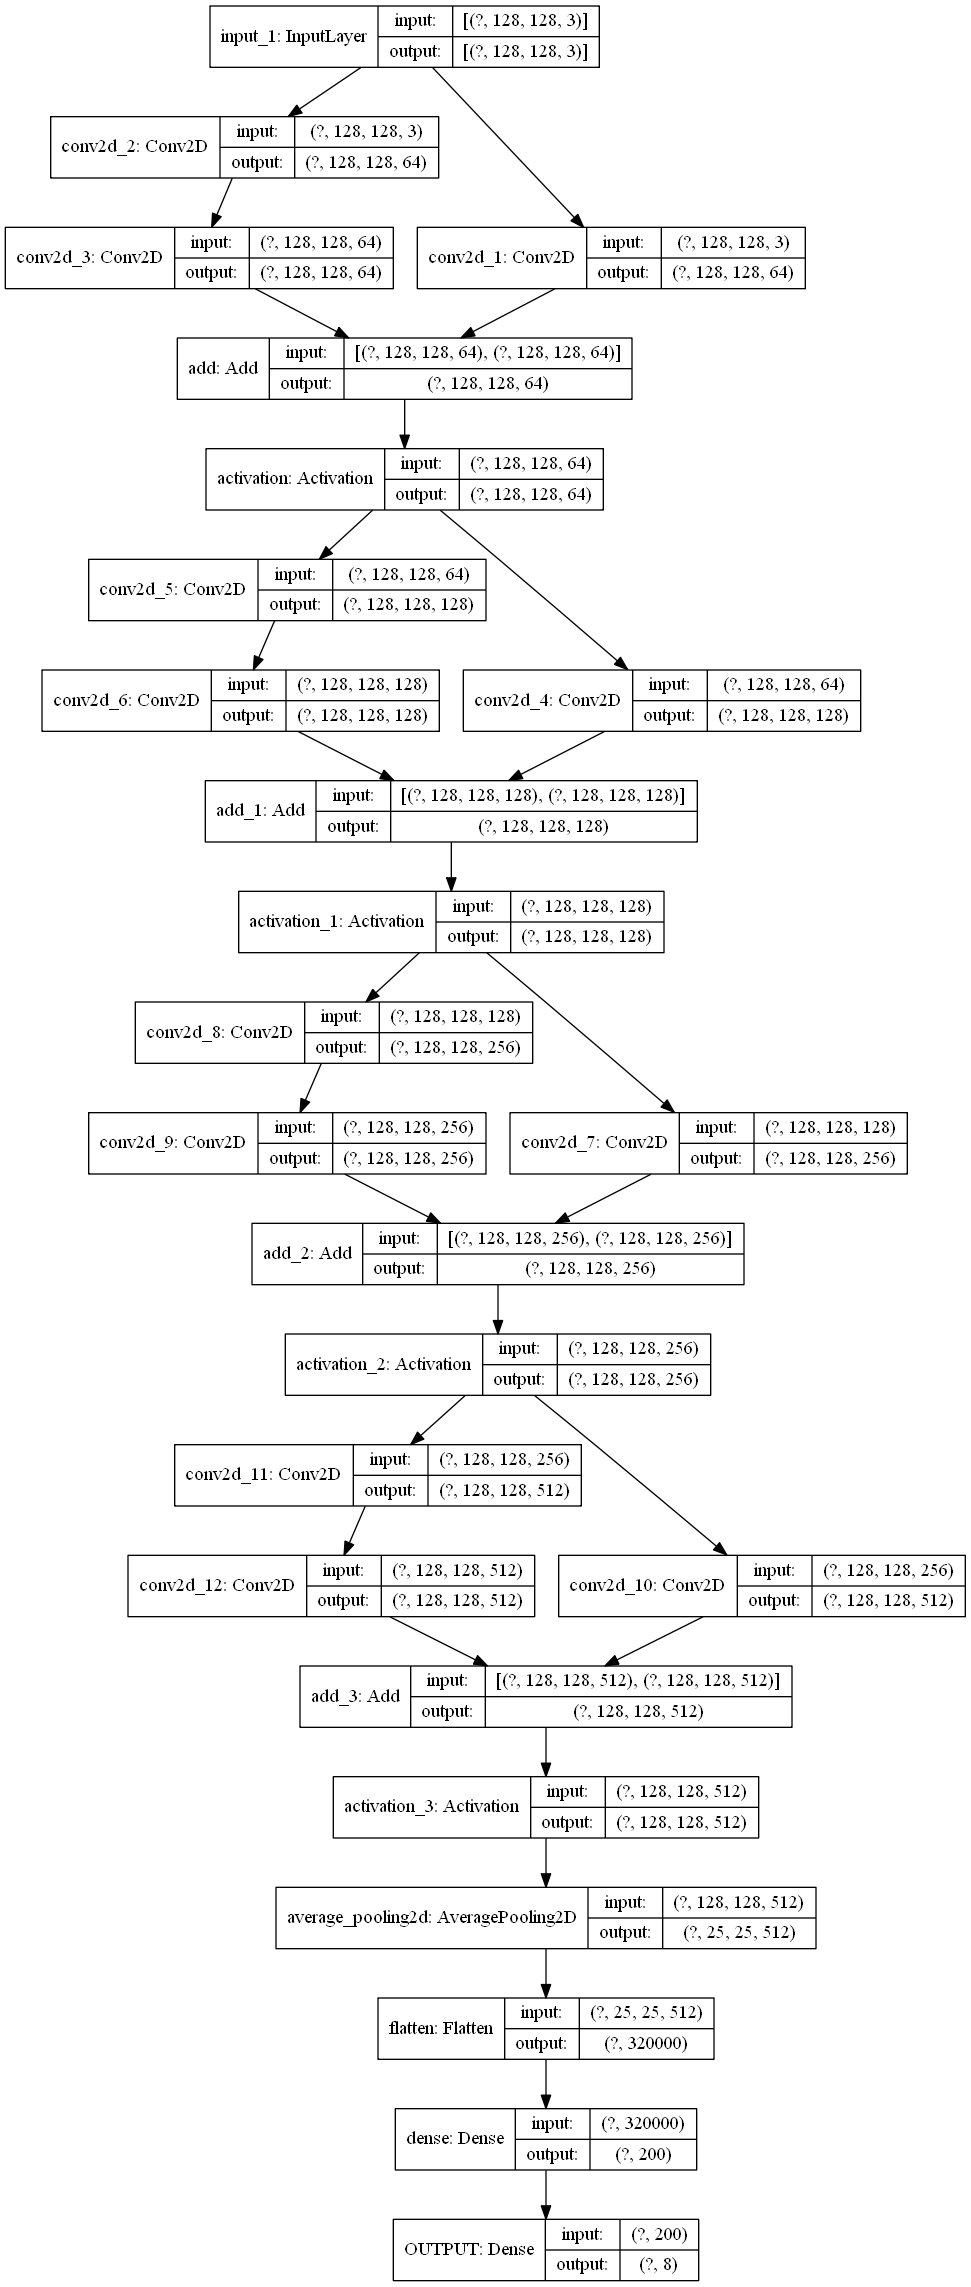

In [12]:
# define model input
visible = Input(shape=(128,128,3))

layer = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(visible) #reduced the filtersize from 32 to 8

#Stacks of 4 residual model
layer = residual_module(visible, 64) #First stack
layer = residual_module(layer, 128) #Second stack
layer = residual_module(layer, 256) #Third stack
layer = residual_module(layer, 512) #Fourth stack

layer = AveragePooling2D((5,5),strides=5)(layer) #Average Pooling layer

layer = Flatten()(layer)

layer = Dense(200, activation='relu')(layer) #FC layer with 200
layer = Dense(len(classes), activation='softmax', name='OUTPUT')(layer) #FC layer with 8 classes

# create model
model = Model(visible,layer)

# summarize model
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='residual_module.png')

### Model Summary
* We see that we have 68,860,368 trainable parameters. The number of parameters depend on the size of the filter and also the total number of filters used. As this uses a deep dense layer we see such a huge number of parameters.

In [ ]:
#Stochastic Gradient Descent optimizer 
opt = SGD(lr=0.01,momentum=0.9,decay=0.01)
from keras.callbacks import EarlyStopping

#Early stopping with a patience of 4 on validation loss
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=4,verbose=0, mode='auto')

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
#Training our 8 class 1500 images per class training dataset on ResNet
start_time=t.time()
history = model.fit(train_images, train_labels,
          validation_data=(test_images, test_labels), 
          epochs=30, batch_size=4, callbacks=[early])
print("\n Training Time: {} seconds".format(t.time()-start_time))

Epoch 1/30
2500/2500 [==============================] - 717s 287ms/step - loss: 2.3877 - accuracy: 0.1193 - val_loss: 2.0801 - val_accuracy: 0.1195
Epoch 2/30
2500/2500 [==============================] - 717s 287ms/step - loss: 2.0796 - accuracy: 0.1219 - val_loss: 2.0801 - val_accuracy: 0.1150
Epoch 3/30
2500/2500 [==============================] - 717s 287ms/step - loss: 2.0794 - accuracy: 0.1278 - val_loss: 2.0797 - val_accuracy: 0.1155
Epoch 4/30
2500/2500 [==============================] - 717s 287ms/step - loss: 2.0789 - accuracy: 0.1293 - val_loss: 2.0787 - val_accuracy: 0.1245
Epoch 5/30
2500/2500 [==============================] - 717s 287ms/step - loss: 2.0752 - accuracy: 0.1377 - val_loss: 2.0536 - val_accuracy: 0.1830
Epoch 6/30
2500/2500 [==============================] - 718s 287ms/step - loss: 2.0437 - accuracy: 0.1833 - val_loss: 1.9830 - val_accuracy: 0.2025
Epoch 7/30
2500/2500 [==============================] - 718s 287ms/step - loss: 1.9782 - accuracy: 0.2276 - val_

In [17]:
#Saving the model
model.save('resnet_n128_colour.h5')

## Combined Model 1
---
* Inspired from AlexNet and Inception module

Model: "Combination_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 30, 30, 96)   34944       input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 14, 14, 96)   0           conv2d_88[0][0]                  
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 14, 14, 256)  614656      max_pooling2d_21[0][0]           
______________________________________________________________________________________

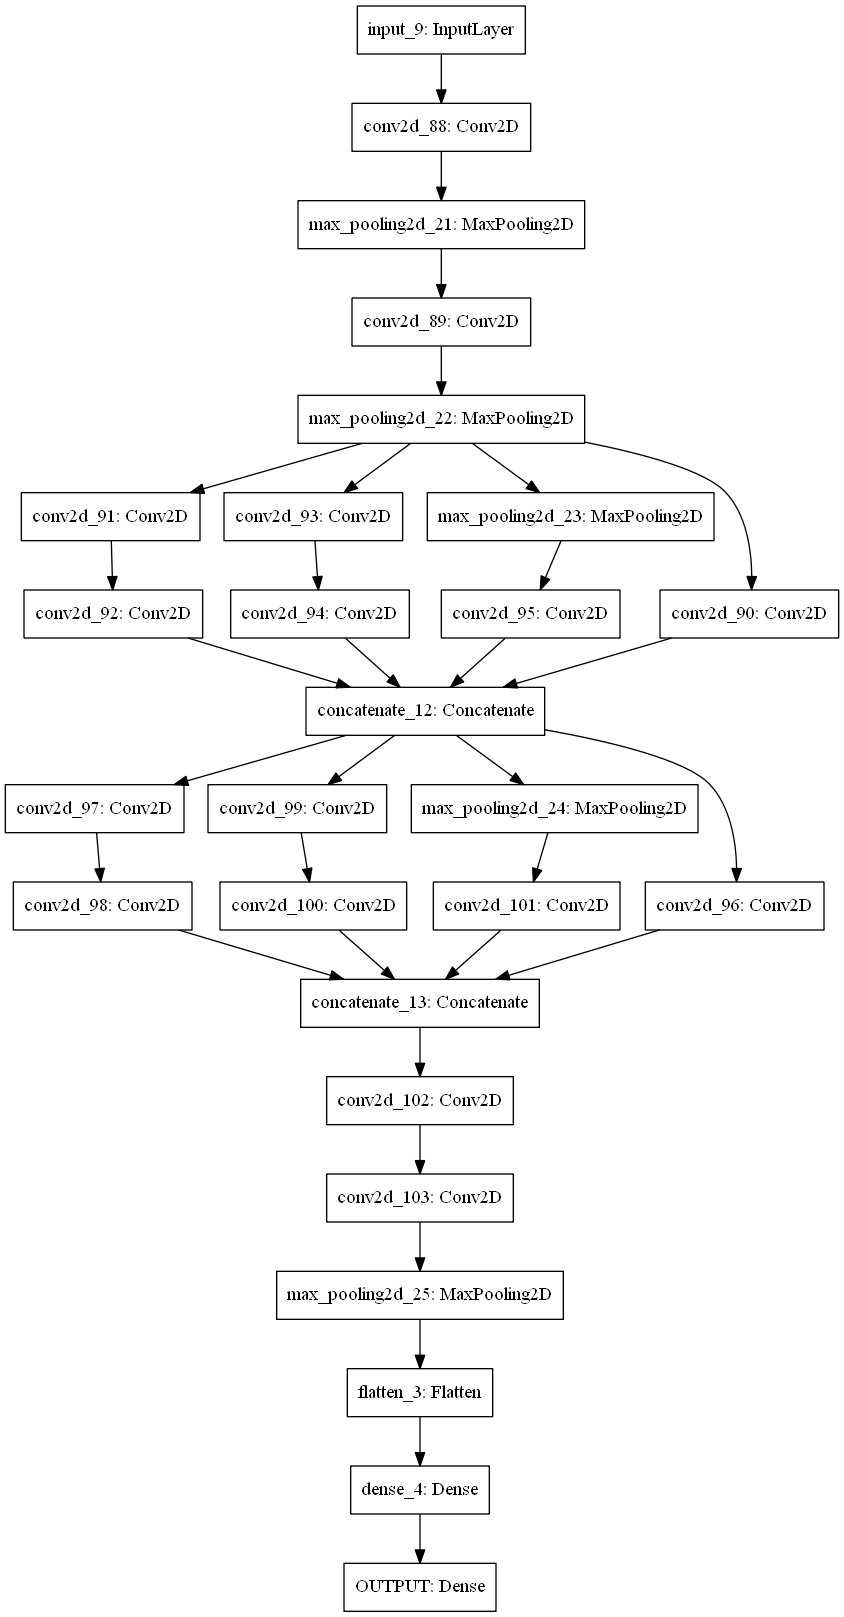

In [36]:
input_layer = Input(shape=(n, n, 3))
m = Conv2D(96,kernel_size=(11,11),strides=(4,4),padding="valid", activation="relu")(input_layer)
m = MaxPooling2D(pool_size=(3,3),strides=(2,2))(m)
m = Conv2D(256, kernel_size=(5,5), padding="same",strides=(1,1), activation="relu")(m)
m = MaxPooling2D(pool_size=(3,3),strides=(2,2))(m)
m = inception_module(m, 160, 112, 224, 24, 64, 64)
m = inception_module(m, 128, 128, 256, 24, 64, 64) 
m = Conv2D(384, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")(m)
m = Conv2D(256, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")(m)
m = MaxPooling2D(pool_size=(3,3),strides=(2,2))(m)
m = Flatten()(m)
m = Dense(4096,activation="relu")(m)
m = Dense(units=len(classes), activation="softmax", name = "OUTPUT")(m)

model4 = Model(input_layer, m, name='Combination_1')

model4.summary()
plot_model(model4)

In [11]:
opt = SGD(lr=0.01,momentum=0.9,decay=0.01)

In [14]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=0, mode='auto')

In [40]:
model4.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
start_time=t.time()
history4 = model4.fit(train_images, train_labels,
          validation_data=(test_images, test_labels), 
          epochs=100, batch_size=64,callbacks=[early])
print("\n Training Time: {} seconds".format(t.time()-start_time))

Epoch 1/100
157/157 [==============================] - 14s 91ms/step - loss: 2.0319 - accuracy: 0.1849 - val_loss: 1.9150 - val_accuracy: 0.2515
Epoch 2/100
157/157 [==============================] - 10s 65ms/step - loss: 1.8166 - accuracy: 0.2834 - val_loss: 2.1114 - val_accuracy: 0.2200
Epoch 3/100
157/157 [==============================] - 11s 69ms/step - loss: 1.6566 - accuracy: 0.3701 - val_loss: 1.4968 - val_accuracy: 0.4470
Epoch 4/100
157/157 [==============================] - 10s 65ms/step - loss: 1.4466 - accuracy: 0.4558 - val_loss: 1.3831 - val_accuracy: 0.4925
Epoch 5/100
157/157 [==============================] - 11s 68ms/step - loss: 1.3376 - accuracy: 0.4998 - val_loss: 1.2881 - val_accuracy: 0.5420
Epoch 6/100
157/157 [==============================] - 11s 68ms/step - loss: 1.2407 - accuracy: 0.5417 - val_loss: 1.2111 - val_accuracy: 0.5590
Epoch 7/100
157/157 [==============================] - 11s 68ms/step - loss: 1.1865 - accuracy: 0.5605 - val_loss: 1.1884 - val_ac

Test Loss -  1.0140718221664429
Test Accuracy -  0.6744999885559082


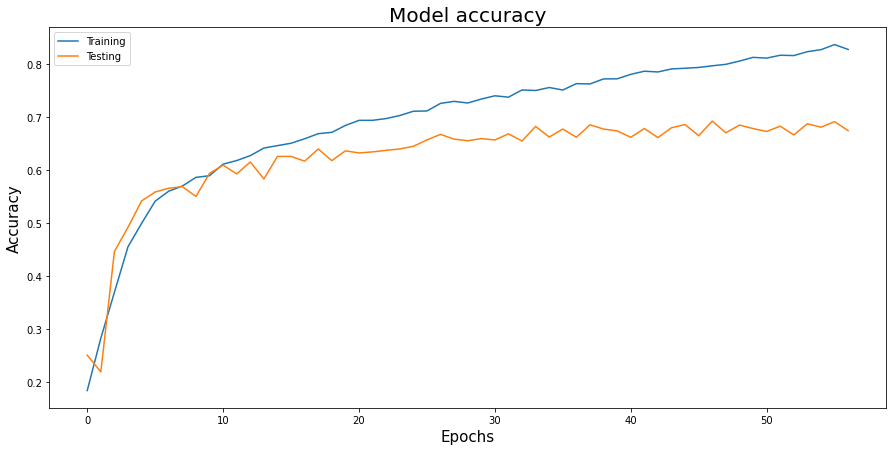

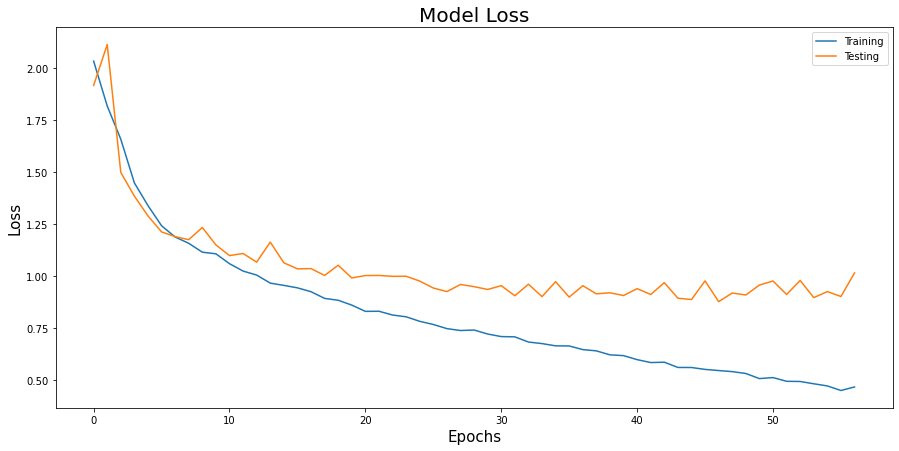

Accuracy of the model: 67.45%


In [45]:
score4 = model4.evaluate(test_images,test_labels,verbose=0)
print('Test Loss - ',score4[0])
print('Test Accuracy - ',score4[1])
graphs(history4,score4)

## Combination model 2
---
* Reduced the overfitting in model 1
* Added another inception model

Model: "Combination_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 30, 30, 96)   34944       input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 96)   0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 14, 14, 256)  614656      max_pooling2d_6[0][0]            
______________________________________________________________________________________

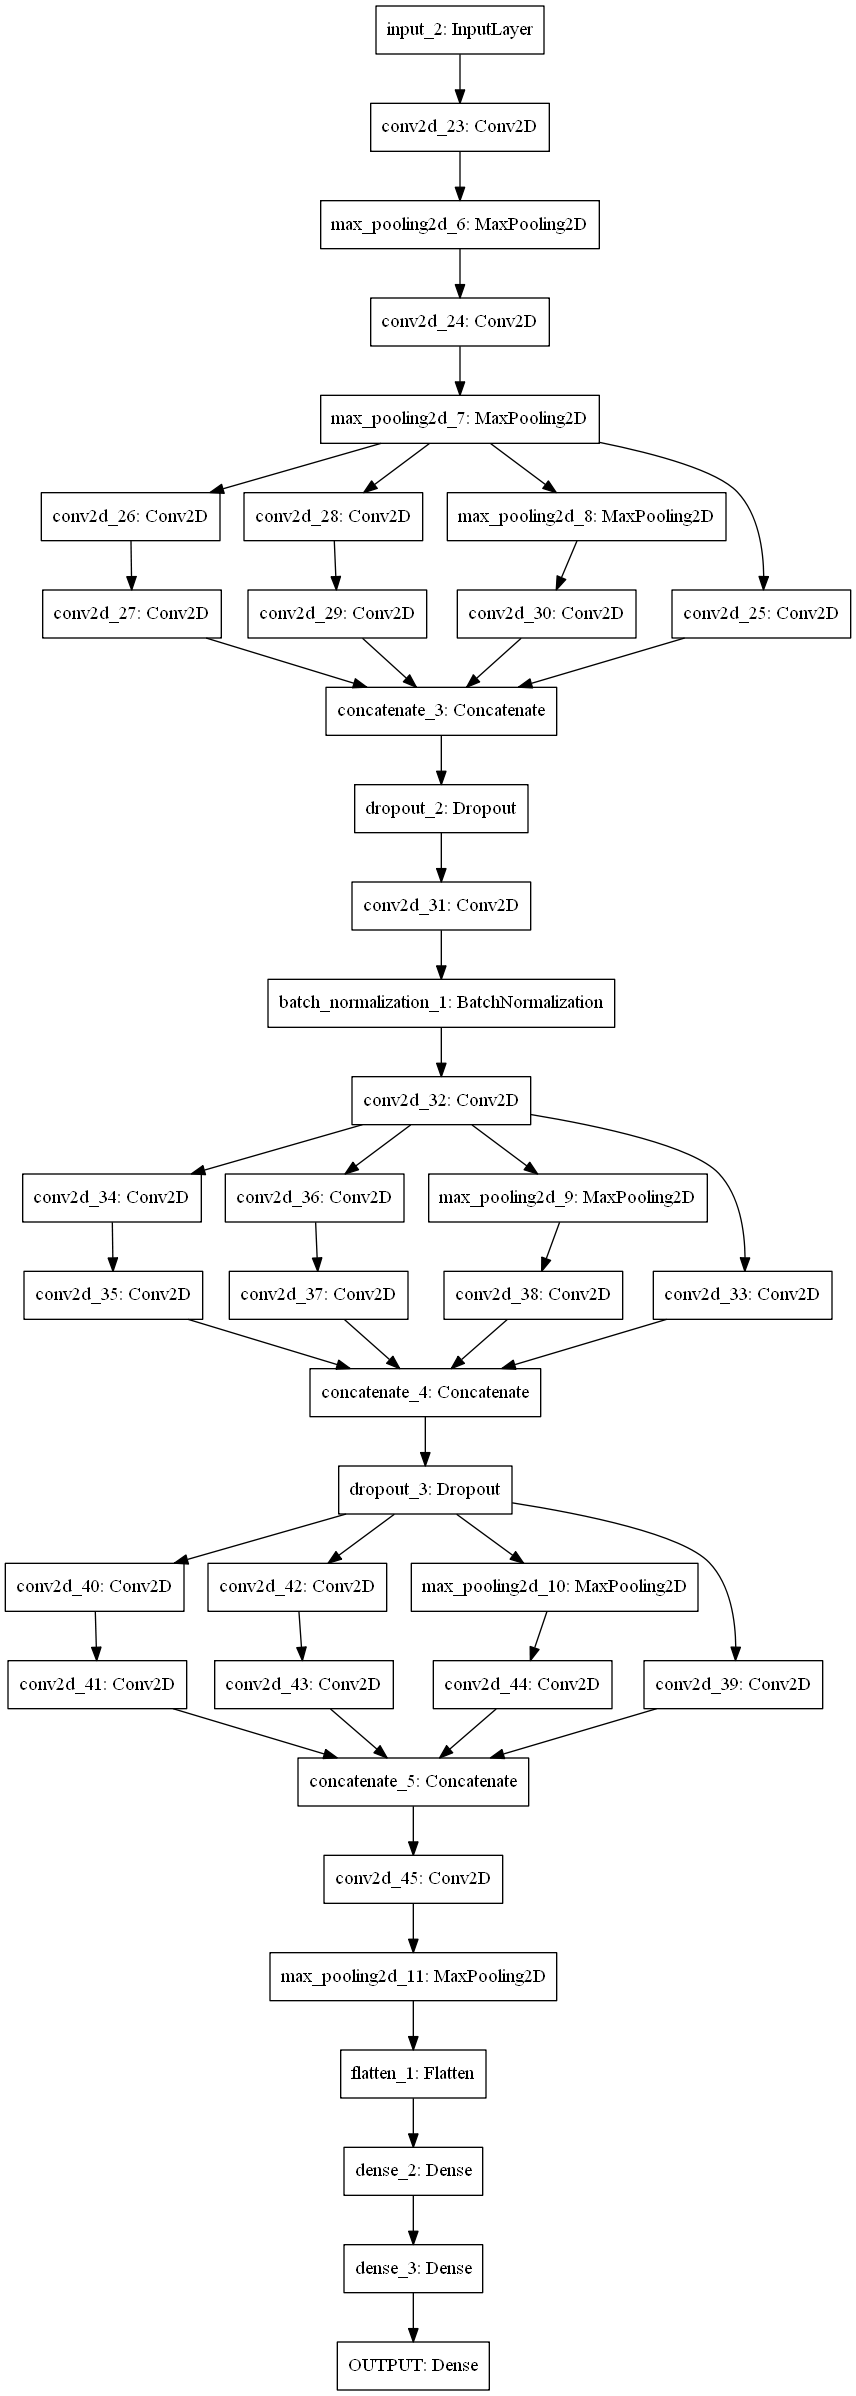

In [15]:
#combination 2
input_layer = Input(shape=(n, n, 3))
m = Conv2D(96,kernel_size=(11,11),strides=(4,4),kernel_initializer=kernel_init, bias_initializer=bias_init,padding="valid", activation="relu")(input_layer)
m = MaxPooling2D(pool_size=(3,3),strides=(2,2))(m)
m = Conv2D(256, kernel_size=(5,5), padding="same",strides=(1,1), activation="relu")(m)
m = MaxPooling2D(pool_size=(3,3),strides=(2,2))(m)
m = inception_module(m, 160, 112, 224, 24, 64, 64)
m = Dropout(0.3)(m)
m = Conv2D(384, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")(m)
m = BatchNormalization()(m)
m = Conv2D(256, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")(m)
m = inception_module(m, 128, 128, 256, 24, 64, 64) 
m = Dropout(0.5)(m)
m = inception_module(m, 128, 128, 256, 24, 64, 64) 
m = Conv2D(256, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu")(m)
m = MaxPooling2D(pool_size=(3,3),strides=(2,2))(m)
m = Flatten()(m)
m = Dense(4096,activation="relu")(m)
m = Dense(4096,activation="relu")(m)
m = Dense(units=len(classes), activation="softmax", name = "OUTPUT")(m)

model5 = Model(input_layer, m, name='Combination_1')

model5.summary()
plot_model(model5)

In [16]:
initial_lrate = 0.01
def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model5.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [18]:
start_time=t.time()
history5 = model5.fit(train_images, train_labels,
          validation_data=(test_images, test_labels), 
          epochs=100, batch_size=64,callbacks=[early,lr_sc])
print("\n Training Time: {} seconds".format(t.time()-start_time))


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
157/157 [==============================] - 12s 79ms/step - loss: 2.0067 - accuracy: 0.1898 - val_loss: 2.0169 - val_accuracy: 0.2345

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
157/157 [==============================] - 11s 70ms/step - loss: 1.7394 - accuracy: 0.3131 - val_loss: 1.7675 - val_accuracy: 0.2940

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
157/157 [==============================] - 11s 70ms/step - loss: 1.4978 - accuracy: 0.4201 - val_loss: 1.6466 - val_accuracy: 0.3695

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
Epoch 4/100
157/157 [==============================] - 11s 70ms/step - loss: 1.3442 - accuracy: 0.4932 - val_loss: 1.4556 - val_accuracy: 0.4570

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
Epoch 5/100
157/157 [==============================] - 11s 71ms/step - loss: 1.2

Test Loss -  0.9669646620750427
Test Accuracy -  0.6890000104904175


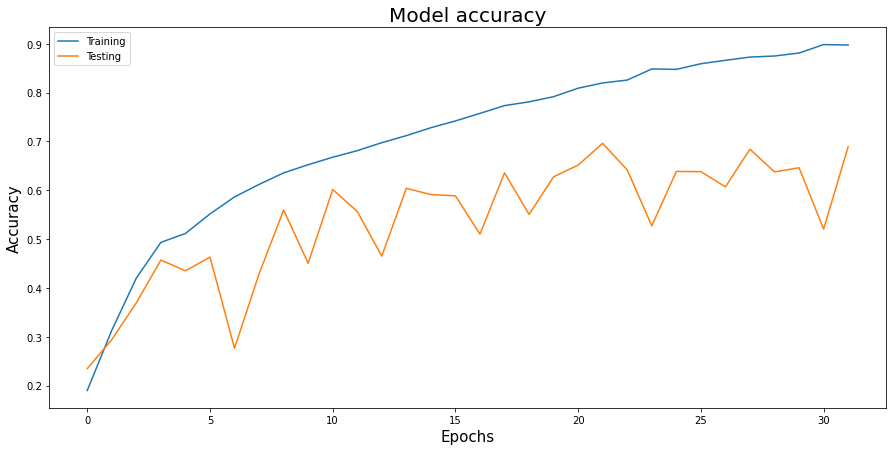

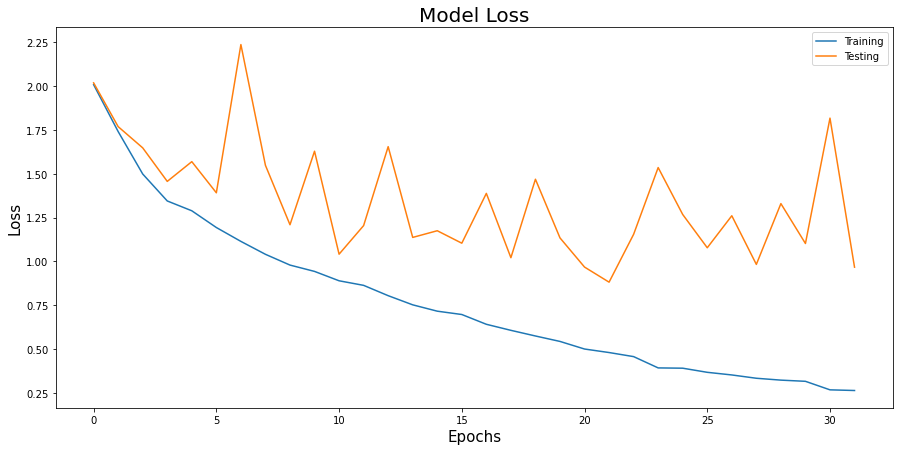

Accuracy of the model: 68.90%


In [19]:
score5 = model5.evaluate(test_images,test_labels,verbose=0)
print('Test Loss - ',score5[0])
print('Test Accuracy - ',score5[1])
graphs(history5,score5)

## Results Discussion
Our Imagenet dataset conists of 8 classes with 1500 colored images in each class. For this dataset with the input size chosen as 128 x 128 with 3 channels the following results are obtained when trained until convergence.

#### Observations
- **VGG-16** - It is a complex deep CNN archietecture with 16 weight layers and 3 fully connected layers. The model has a total of 64.5 million trainable parameters. The model produces an accuracy of **60.50 %** over the test data.  
- **VGG-19** - It is a variant of model 1 with 19 weight layers and 3 fully connected layers. It has a total of 70 million parameters. The model produces an accuracy of **59.64 %** over the test data.
-  **AlexNet** - This model is comparatively shallow than the other 2 models with only 5 weight layers and 3 fully connected layers. The models consists of 24.8 million trainable parameters and produces an accuracy of **68.50 %**  over the test data.
-  **GoogleNet** - Used inception module, it provided an accuracy of **69.74 %** on the test data. This is the highest accuracy obtained on the test data.
-  **ResNet** - Used residual module, it provided an accuracy of **58.85 %** on the test data. 
-  **Combined Model 1** - It is a combination of AlexNet and Inception module. The model is shallow with two inception  module. The test accuracy was **67.55 %** the model was slightly overfitting, which was observed from the loss.
-  **Combined Model 2** - It is a variation of combined model 1. Few regularizing parameters were added along with one more inception module, thus making it 3 inception mudules. The test accuracy was **69.55 %**, which was the second best accuracy observed on the test data.

#### Key Inference
- We can see that the more shallow  **AlexNet model** has performed very well over the dataset, there are many reasons that attribute to this. It can be due to the fact that the images are considered at a **lowered pixel ratio**, in which some of the valuable features may be lost.
- We observe **GoogleNet** performed very well on the data. This is mainly **attributed to the inception modules.**
- The **Combined model using the inception model**, seemingly provided better results which can clearly supports the above stated claim.
- The **relatively less performance of the VGG-19 model** when compared with VGG-16 can be **attributed to the depth of the CNN archieture.** The input parameters are very less when considered with the actual depth of the model, as increased number of layers with less features to catch can reduce the activation of neurons with certain features and due to the implicit regularizatons because of the depth of the model.
- Since the data set has only 1500 images for consideration and some of these images were seen to having **obstructions such as human interventions**, the model may be restricted to learn only certain features of the data, if trained on more data which is clean, the performance of the model can be considerably increased.
- Another potential factor that could be affecting the for model's performance is **cropping the image**. Although we crop the image from the lowest side in order to capture the maximum features out of it, in some cases the part of the image that is discarded may contain much more feature information than expected, which can be addresed by increasing the dataset size. By increasing the size of the data, these missed features may not affect the models performance as the probability that all the cropped images miss the same features is very less.
#### Room for Improvements
- The current model only uses 1500 images per class to train. Increasing the datasets size would increase the accuracy to a very good extent.
- Increasing the input image size. Current Model uses 128 x 128 images, increasing the size would give more additional information to extract, thus increasing the performance.
- Using data augumentaion, can also improve accuracy of the model.